In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import matplotlib.pyplot as plt
import pyrcn
from pyrcn.base.blocks import InputToNode, NodeToNode
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from chex import Array, Scalar
from typing import Tuple

from esn import ESN
from utils import chunkify, plot_predictions

key = jax.random.PRNGKey(43)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


# Data

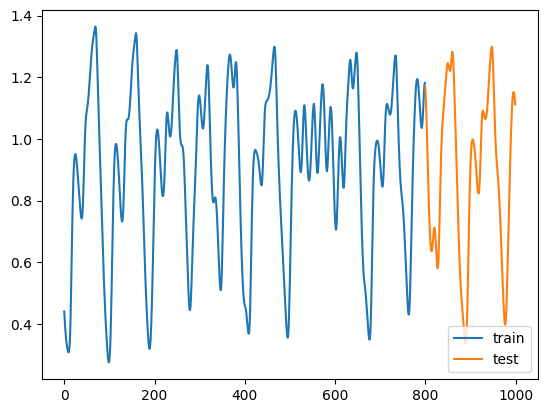

X train-test shapes: (10, 790)	(10, 190)
Y train-test shapes: (1, 790)	(1, 190)


In [3]:
N_SAMPLES = 1000
SPLIT_RATIO = 0.8
HISTORY_LEN = 10
FORECAST_LEN = 1

# Load from csv file
mackey_data = jnp.squeeze(jnp.array(pd.read_csv("data/MackeyGlass_1k.csv", index_col=0)))
# mackey_data = jnp.linspace(-1, 1, n_samples)

# Split into train-test
split = int(SPLIT_RATIO * N_SAMPLES)
mackey_train = mackey_data[:split]
mackey_test = mackey_data[split:]

# Plot
plt.plot(jnp.arange(0, split, dtype=jnp.int32), mackey_train, label="train")
plt.plot(jnp.arange(split, N_SAMPLES, dtype=jnp.int32), mackey_test, label="test")
plt.legend()
plt.show()

# Split into input and output
X_train, Y_train = chunkify(mackey_train, HISTORY_LEN, FORECAST_LEN)
X_test, Y_test = chunkify(mackey_test, HISTORY_LEN, FORECAST_LEN)

X_train_np, Y_train_np = np.array(X_train), np.array(Y_train)
X_test_np, Y_test_np = np.array(X_test), np.array(Y_test)

print(f"X train-test shapes: {X_train.shape}\t{X_test.shape}")
print(f"Y train-test shapes: {Y_train.shape}\t{Y_test.shape}")

# My ESN Implementation

In [4]:
best_params = {'hidden_nodes': 69, 'leakage': 0.3156014208642396, 'l2_cost': 628.7829947402206} # key=71
# best_params = {'hidden_nodes': 15, 'leakage': 0.05100535804588711, 'l2_cost': 3.8437666713738663} # key=72

In [7]:
my_ESN = ESN(
    jax.random.PRNGKey(71),
    hidden_nodes=best_params["hidden_nodes"],
    sparsity_in=1.0,
    sparsity_node=1.0,
    input_activation=lambda x: x,
    node_activation=jax.nn.relu,
    spectral_radius=1.0,
    leakage=best_params["leakage"],
    l2_cost=best_params["l2_cost"]
)

### Train validation

MSE train: 0.017968790605664253


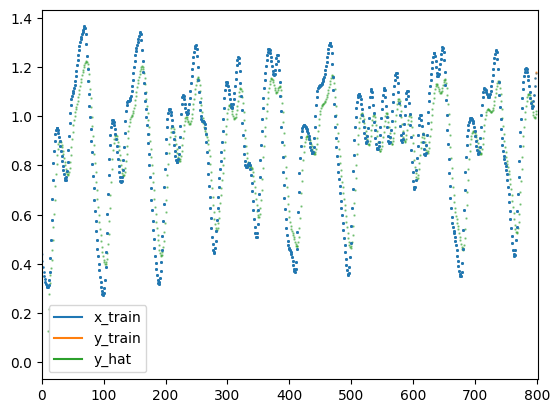

In [8]:
y_hat_train = my_ESN.fit(X_train, Y_train)
mse_train = mean_squared_error(Y_train, y_hat_train)
print(f"MSE train: {mse_train}")
plot_predictions(X_train, Y_train, y_hat_train, HISTORY_LEN, FORECAST_LEN)

### Test validation

Test MSE: 0.01900148019194603


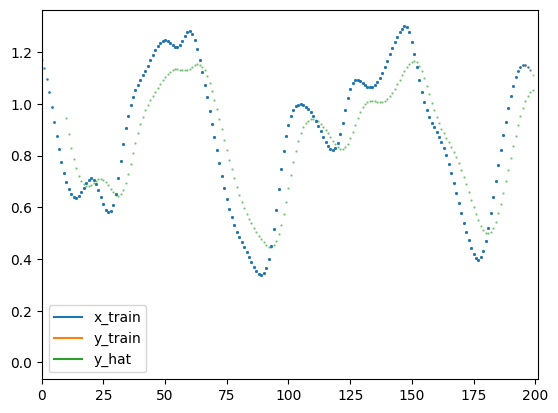

In [9]:
y_hat_test = my_ESN.predict(X_test)
mse_test = mean_squared_error(Y_test, y_hat_test)
print(f"Test MSE: {mse_test}")
plot_predictions(X_test, Y_test, y_hat_test, HISTORY_LEN, FORECAST_LEN)

# PyRCN Implementation

### Train Validation

In [10]:
input_to_node = InputToNode(
    hidden_layer_size=100,
    k_in=None,
    sparsity=1.0,
    input_activation="identity",
)
node_to_node = NodeToNode(
    hidden_layer_size=100,
    sparsity=1.0,
    reservoir_activation="tanh",
    spectral_radius=1.0,
    leakage=0.9,
    bidirectional=False
)

In [11]:
R_i2n = input_to_node.fit_transform(X_train_np.T)
R_n2n = node_to_node.fit_transform(R_i2n)
ridge_train = Ridge(alpha=50).fit(R_n2n, np.squeeze(Y_train_np))

MSE train: 0.0025945347190865016


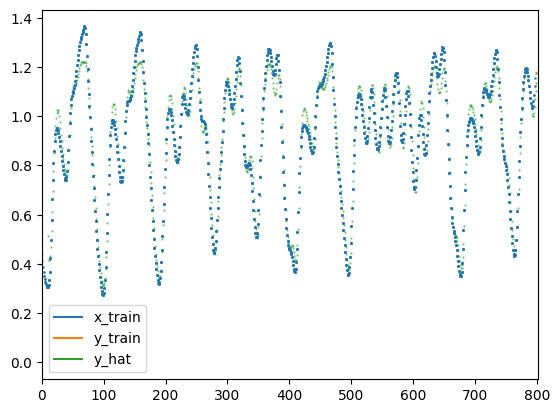

In [12]:
y_hat_train_pyrcn = ridge_train.predict(R_n2n)
mse_train_pyrcn = mean_squared_error(Y_train.T, y_hat_train_pyrcn)
print(f"MSE train: {mse_train_pyrcn}")
plot_predictions(X_train_np, Y_train_np, np.expand_dims(y_hat_train_pyrcn, 0), HISTORY_LEN, FORECAST_LEN)

### Test Validation

In [13]:
R_i2n_test = input_to_node.fit_transform(X_test_np.T)
R_n2n_test = node_to_node.fit_transform(R_i2n_test)

Test MSE: 0.002461418845895418


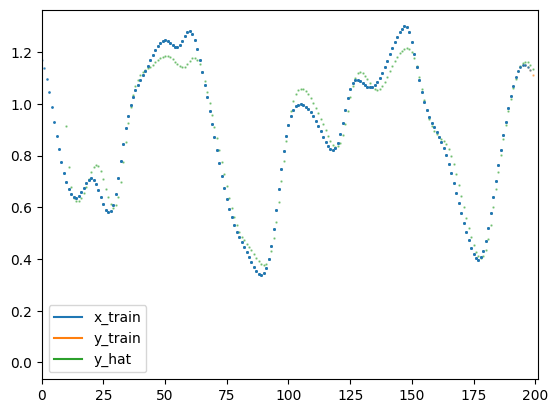

In [14]:
y_hat_test_pyrcn = ridge_train.predict(R_n2n_test)
mse_test_pyrcn = mean_squared_error(Y_test.T, y_hat_test_pyrcn)
print(f"Test MSE: {mse_test_pyrcn}")
plot_predictions(X_test_np, Y_test_np, np.expand_dims(y_hat_test_pyrcn, 0), HISTORY_LEN, FORECAST_LEN)

# Execution time

In [39]:
def measure_my_implementation(l2):

    esn_time = ESN(
        jax.random.PRNGKey(71),
        hidden_nodes=69,
        sparsity_in=1.0,
        sparsity_node=1.0,
        input_activation=lambda x: x,
        node_activation=jax.nn.relu,
        spectral_radius=1.0,
        leakage=0.5,
        l2_cost=l2
    )
    esn_time.fit(X_train, Y_train)


def measure_pyrcn_implementation(l2):
    
    input_to_node = InputToNode(
        hidden_layer_size=100,
        k_in=None,
        sparsity=1.0,
        input_activation="identity",
    )
    node_to_node = NodeToNode(
        hidden_layer_size=100,
        sparsity=1.0,
        reservoir_activation="tanh",
        spectral_radius=1.0,
        leakage=0.9,
        bidirectional=False
    )
    R_i2n = input_to_node.fit_transform(X_train_np.T)
    R_n2n = node_to_node.fit_transform(R_i2n)
    ridge_train = Ridge(alpha=50).fit(R_n2n, np.squeeze(Y_train_np))

In [38]:
for l2 in jnp.linspace(0, 1000, 100):
    measure_my_implementation(l2)

In [ ]:
for l2 in jnp.linspace(0, 1000, 100):
    measure_pyrcn_implementation(l2)

# Sandbox

## TODO
- Compare exec times